# Exploring GABRIL's atari dataset

In [1]:
import torch

data = torch.load('/scr/nityakas/GABRIL-Atari/extending_GABRIL/dataset/Breakout/num_episodes_20_fs4_human.pt', weights_only=False)

In [2]:
type(data)

dict

In [3]:
data.keys()

dict_keys(['observations', 'ram', 'episode-rewards', 'actions', 'steps', 'terminateds', 'truncateds', 'gaze_information'])

In [4]:
data['truncateds']

array([False, False, False, ..., False, False, False], shape=(23049,))

In [5]:
data['observations']

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

*Why 23069 observations but only 23049 actions, gaze information, and truncateds?* Bc the remaining 20 are terminal states, which lines up w the fact that there are only 20 episodes. terminal states wont have actions or gaze info obvi but also no truncated bc truncated flag is only for the transitions, which there'll only be 23049 of.

Also fatemeh said the first two elements correspond to X and Y.
The third one indicates the index of the most recent frame in which the gaze tracker device provided valid data. We mainly included it for internal checks to ensure the gaze tracking process was running properly. You can just ignore the last one.

# Method 1: Patch the human gaze mask

This would essentially downsample the gaze mask down to a grid of patch_size x patch_size. I'm worried that this information loss will worsen performance as opposed to method 2: upsampling the CLS token's QK_t weight matrix

In [ ]:
import sys
sys.path.append('..') # allows me to pull from GABRIL_utils/ which is a sibling directory to dev/

from GABRIL_utils.gaze_to_mask import GazeToMask
from GABRIL_utils.utils import load_dataset

In [42]:
env = 'Breakout'
seed = 42
datapath = 'dataset/'
conf_type='normal'
train_type = 'normal'
conf_randomness = 0.0
stack = 1
num_episodes = 2
use_gaze = True
gaze_method = 'Reg'
data_source = 'Our'
gaze_mask_sigma=gaze_mask_sigma = 15.0
gaze_mask_coef=gaze_mask_coeff = 0.7

patch_size = (14, 14)

In [9]:
observations, actions, gaze_masks, gaze_coordinates = load_dataset(
        env=env,
        seed=seed,
        datapath=datapath,
        conf_type=conf_type,
        conf_randomness=conf_randomness,
        stack=stack,
        num_episodes=num_episodes,
        use_gaze=use_gaze,
        data_source=data_source,
        gaze_mask_sigma=gaze_mask_sigma,
        gaze_mask_coef=gaze_mask_coeff                
    )

100%|██████████| 2/2 [00:00<00:00, 151.18it/s]


In [10]:
gaze_masks[0].shape

torch.Size([1, 84, 84])

In [58]:
idx = 20

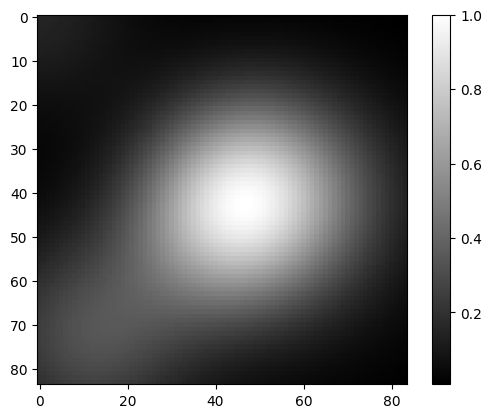

In [59]:
import matplotlib.pyplot as plt

plt.imshow(gaze_masks[idx].squeeze().numpy(), cmap='gray')
plt.colorbar()
plt.savefig(f'mask{idx}_og.jpeg')
plt.show() 


In [ ]:
from utils.patch_gaze_masks import patch_gaze_masks
gaze_patches = patch_gaze_masks(gaze_masks=gaze_masks, patch_size=patch_size)

In [27]:
gaze_masks.shape # only 2198 timesteps because i only processed the first 2 episodes worth of data

torch.Size([2198, 1, 84, 84])

In [60]:
gaze_patches[idx]

tensor([[0.0226, 0.0216, 0.0217, 0.0221, 0.0216, 0.0208, 0.0216, 0.0228, 0.0269,
         0.0299, 0.0268, 0.0228, 0.0217, 0.0261, 0.0381, 0.0466, 0.0363, 0.0257,
         0.0235, 0.0291, 0.0420, 0.0490, 0.0369, 0.0258, 0.0263, 0.0294, 0.0326,
         0.0329, 0.0278, 0.0231, 0.0268, 0.0271, 0.0251, 0.0236, 0.0222, 0.0211]])

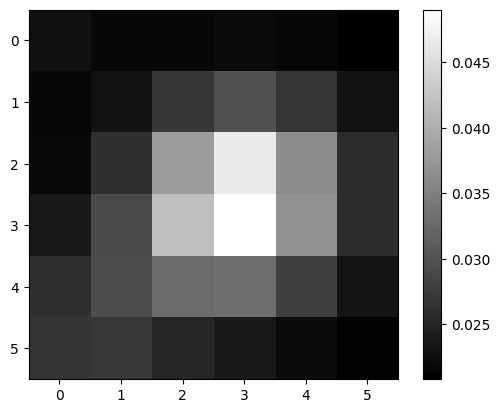

In [61]:
from einops import rearrange

h = w = int(84/patch_size[0]) # bc returns float by default even if its int.0, then that breaks rearrange() below

# grid = rearrange(gaze_patches[idx], 'f (h w) -> f h w', h=h, w=w)
grid = gaze_patches[idx].view(1, h, w)

plt.imshow(grid.squeeze().numpy(), cmap='gray')
plt.colorbar()
plt.savefig(f'mask{idx}_patched_{patch_size[0]}x{patch_size[1]}.jpeg') # add before show() bc show() clears the figure!
plt.show() 

In [63]:
# save the patchified gaze masks into a .pt file for later use
torch.save(gaze_patches, f"Breakout_gaze_patched_onlyfirst2eps_{patch_size[0]}x{patch_size[1]}.pt")

confirm the saving happened in expected format:

In [ ]:
gaze_patches_from_file = torch.load(f"Breakout_gaze_patched_onlyfirst2eps{patch_size[0]}x{patch_size[1]}.pt")
gaze_patches_from_file[idx]

tensor([[0.0166, 0.0164, 0.0163, 0.0163, 0.0163, 0.0162, 0.0161, 0.0165, 0.0165,
         0.0167, 0.0169, 0.0168, 0.0165, 0.0163, 0.0167, 0.0172, 0.0178, 0.0182,
         0.0178, 0.0170, 0.0164, 0.0186, 0.0201, 0.0208, 0.0205, 0.0191, 0.0175,
         0.0166, 0.0247, 0.0286, 0.0271, 0.0231, 0.0197, 0.0176, 0.0165, 0.0333,
         0.0404, 0.0336, 0.0242, 0.0192, 0.0171, 0.0164, 0.0324, 0.0379, 0.0306,
         0.0220, 0.0180, 0.0166, 0.0162]])

In [21]:
gaze_patches_from_file.shape

torch.Size([2198, 1, 49])

- 2198 is the combined timesteps from the first 2 episodes. 
- 1 is the frame history provided to the model (1 means only the current frame and no past history). this could be useful if say u were training a model to predict the speed of an object, you'd give it a few past frames too so it could infer velocity
- 49 patches come from the 84x84 original image being divided by a 12x12 patch size 

# method 2: Upsample the CLS token's QK_t weight matrix

My initial idea was to upsample the softmax-ed weights, but Yutai thinks you should upsample the logits, then softmax across that whole thing